# MAGICC temperature IRF

Here we calculate an impulse-response function to match MAGICC's behaviour.

## Authors

All notebooks and plots in this repository were generated by the following authors:

- Zebedee Nicholls zebedee.nicholls@climate-energy-college.org
- Jared Lewis jared.lewis@climate-resource.com
- Malte Meinshausen malte.meinshausen@unimelb.edu.au

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import os.path
import warnings
from concurrent.futures import as_completed, ProcessPoolExecutor

import matplotlib.pyplot as plt
import numpy as np
import openscm_twolayermodel
import pandas as pd
import scmdata.database
import scipy.optimize
import seaborn as sns
import tqdm.autonotebook as tqdman
from openscm_units import unit_registry

/data/ubuntu-znicholls/miniconda3/envs/ar6-wg1-plots-and-processing/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [4]:
import utils

<IPython.core.display.Javascript object>

In [5]:
MAX_WORKERS = 20

<IPython.core.display.Javascript object>

In [6]:
now = dt.datetime.now()
# datestamp = now.strftime("%Y_%m_%d_%H%M%S")
datestamp = "2021_02_17_233041"
datestamp

'2021_02_17_233041'

<IPython.core.display.Javascript object>

In [7]:
OUT_FILE = os.path.join(
    utils.DATA_DIR, "processed", "temperature_irfs", f"irf_from_2xCO2_{datestamp}.csv"
)
OUT_FILE

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/irf_from_2xCO2_2021_02_17_233041.csv'

<IPython.core.display.Javascript object>

In [8]:
OUT_FILE_RECOMMENDATION = os.path.join(
    utils.DATA_DIR,
    "processed",
    "temperature_irfs",
    f"recommended_irf_from_2xCO2_{datestamp}.csv",
)
OUT_FILE_RECOMMENDATION

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/recommended_irf_from_2xCO2_2021_02_17_233041.csv'

<IPython.core.display.Javascript object>

In [9]:
IN_DIR = os.path.join(utils.MAGICC_OUTPUT_DIR, utils.MAGICC_IDEALISED_OUTPUT_DIR)
IN_DIR

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/raw/magicc/v20210217/output_210_idealised_experiments_2021_02_17_230201'

<IPython.core.display.Javascript object>

In [10]:
db = scmdata.database.ScmDatabase(
    IN_DIR, levels=("climate_model", "variable", "scenario")
)
db

<scmdata.database.SCMDatabase (root_dir: /data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/raw/magicc/v20210217/output_210_idealised_experiments_2021_02_17_230201, levels: ('climate_model', 'variable', 'scenario'))>

<IPython.core.display.Javascript object>

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

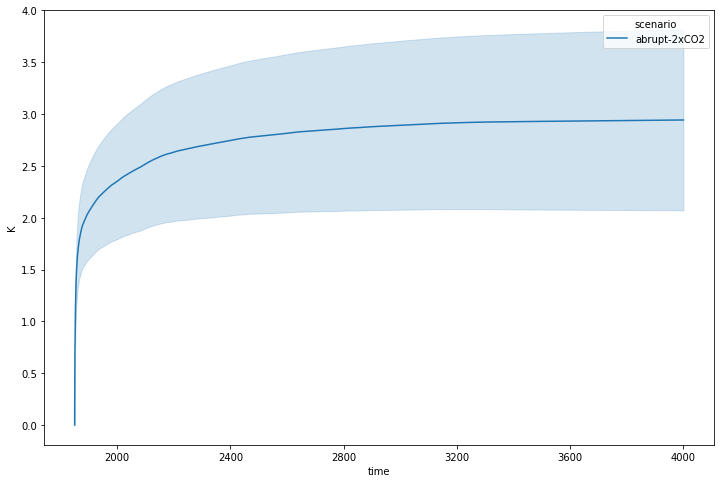

<IPython.core.display.Javascript object>

In [11]:
surface_temps = db.load(
    variable="Surface Air Temperature Change", scenario="abrupt-2xCO2"
)
surface_temps.lineplot()

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

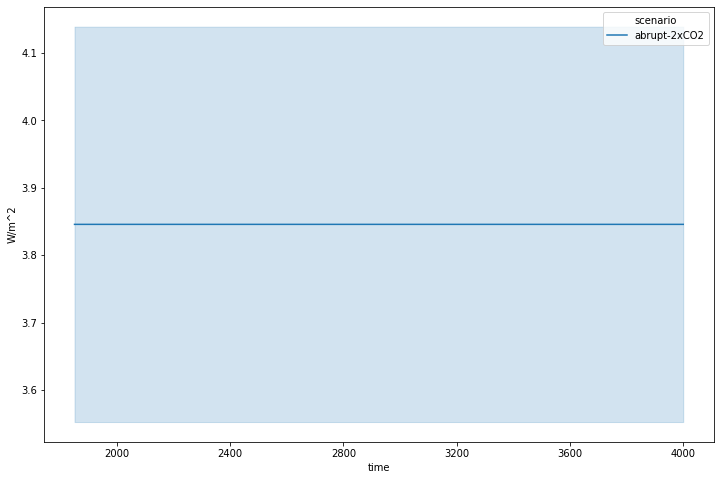

<IPython.core.display.Javascript object>

In [12]:
erfs = db.load(variable="Effective Radiative Forcing", scenario="abrupt-2xCO2")
erfs.lineplot()

## Create IRF

We only use the median response for these IRFs.

time                                                                               1850-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1                   0.0   

time                                                                               1851-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1               0.68182   

time                                                                               1852-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              0.958708   

time                                                                               1853-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.142461   

time                                                                               1854-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.274919   

time                                                                               1855-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.367651   

time                                                                               1856-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.441076   

time                                                                               1857-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.507478   

time                                                                               1858-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.555013   

time                                                                               1859-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              1.594363   

time                                                                               ...  \
model       variable                       region scenario     unit climate_model  ...   
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1   ...   

time                                                                               3991-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecified Surface Air Temperature Change World  abrupt-2xCO2 K    MAGICCv7.5.1              2.942227   

time                                                                               3992-01-01 00:00:00  \
model       variable                       region scenario     unit climate_model                        
unspecif

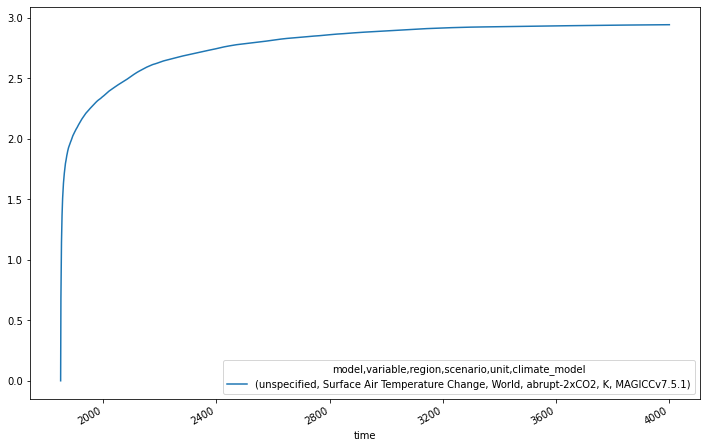

<IPython.core.display.Javascript object>

In [13]:
surface_temp_median = surface_temps.process_over("ensemble_member", "median")
ax = surface_temp_median.T.plot()

surface_temp_median

time                                                                             1850-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1851-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1852-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1853-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1854-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1855-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1856-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1857-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1858-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             1859-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             ...  \
model       variable                    region scenario     unit  climate_model  ...   
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1   ...   

time                                                                             3991-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1              3.845693   

time                                                                             3992-01-01 00:00:00  \
model       variable                    region scenario     unit  climate_model                        
unspecified Effective Radiative Forcing World  abrupt-2xCO2 W/m^2 MAGICCv7.5.1      

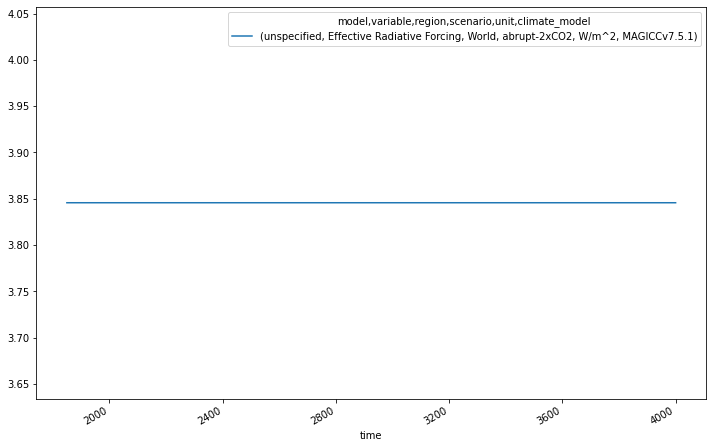

<IPython.core.display.Javascript object>

In [14]:
erf_median = erfs.process_over("ensemble_member", "median")
erf_median.T.plot()
erf_median_single = erf_median.iloc[0, 0]
erf_median

scenarios: 0it [00:00, ?it/s]

time                                                                                                                                                                                                                                                                                             1850-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / delta_degree_Celsius / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model       region run_idx scenario     unit       variable                                           
0.0                                               two_layer     1200       50         1.0                      0.8                                            1.246667                                           unspecified World  0       abrupt-2xCO2 W/m^2      Effective Radiative Forcing             3.845693   
                                                                                                                                                                                                                                                         delta_degC Surface Temperature|Upper               0.000000   
                                                                                                                                                                                                                                                                    Surface Temperature|Lower               0.000000   
                                                                                                                                                                                                                                                         W/m^2      Heat Uptake                             0.000000   

time                                                                                                                                                                                                                                                                                             1851-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / delta_degree_Celsius / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model       region run_idx scenario     unit       variable                                           
0.0                                               two_layer     1200       50         1.0                      0.8                                            1.246667                                           unspecified World  0       abrupt-2xCO2 W/m^2      Effective Radiative Forcing             3.845693   
                                                                                                                                                                                                                                                         delta_degC Surface Temperature|Upper               0.580535   
                                                                                                                                                                                                                                                                    Surface Temperature|Lower               0.000000   
                                                                                                                                                                                                                                                         W/m^2      Heat Uptake                             3.845693   

time                                                                                                                                                                                                                                                          

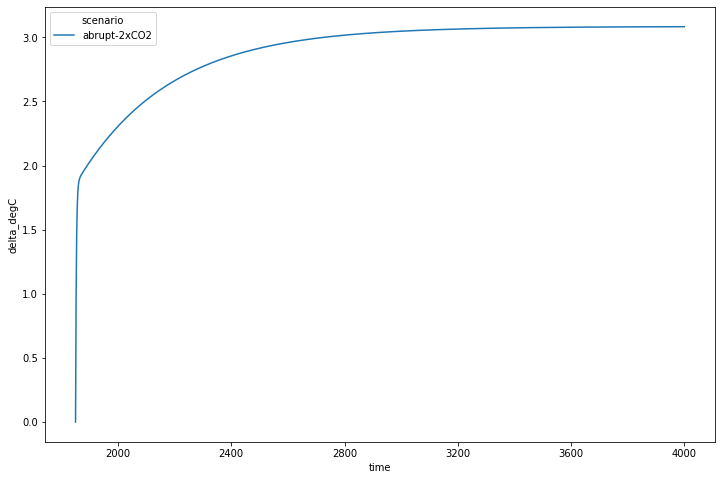

<IPython.core.display.Javascript object>

In [15]:
impulse_response = openscm_twolayermodel.TwoLayerModel()
res_impulse_response = impulse_response.run_scenarios(scmdata.ScmRun(erf_median.copy()))
res_impulse_response.filter(variable="Surface Temperature|Upper").lineplot()
res_impulse_response.head()

In [16]:
def get_irf_model(in_vec):
    dl, du, eta, lambda0, efficacy = in_vec

    impulse_response = openscm_twolayermodel.TwoLayerModel(
        dl=dl * unit_registry("m"),
        du=du * unit_registry("m"),
        eta=eta * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
        lambda0=lambda0 * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
        efficacy=efficacy * unit_registry("dimensionless"),
    )

    return impulse_response

<IPython.core.display.Javascript object>

In [17]:
def get_best_fit(target_values, driver, em=None):
    def min_func(in_vec):
        impulse_response = get_irf_model(in_vec)

        impulse_response.set_drivers(
            driver.values.squeeze().copy() * unit_registry("W / m^2")
        )
        impulse_response.reset()
        impulse_response.run()

        gsat = impulse_response._temp_upper_mag

        diff = (gsat - target_values.values).squeeze()
        diff_sum = np.abs(diff[:]).sum()

        # give the first X years extra weight
        extra_weight_times = 80
        extra_weight = 20
        diff = (extra_weight - 1) * (
            gsat[:extra_weight_times] - target_values.values[0, :extra_weight_times]
        ).squeeze()
        diff_sum += np.abs(diff[:]).sum()

        return diff_sum

    p0 = [1200, 50, 0.8, 1.24666, 1]
    bounds = (
        (800, 4000),
        (20, 400),
        (0.1, 2),
        (0.2, 4),
        (0.2, 4),
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        opt_res = scipy.optimize.minimize(
            min_func,
            p0,
            #             method="Nelder-Mead",
            bounds=bounds,
        )

    best_model = get_irf_model(opt_res.x)

    if em is not None:
        return best_model, em

    return best_model

<IPython.core.display.Javascript object>

In [18]:
best_model = get_best_fit(surface_temp_median, erf_median)
display(best_model.lambda0)
display(best_model.heat_capacity_lower.to("W yr / m^2 / K"))
display(best_model.heat_capacity_upper.to("W yr / m^2 / K"))
best_model

1.3157602559179795 <Unit('watt / delta_degree_Celsius / meter ** 2')>

158.98595702280957 <Unit('a * watt / kelvin / meter ** 2')>

6.635936577189717 <Unit('a * watt / kelvin / meter ** 2')>

<IPython.core.display.Javascript object>

In [19]:
best_res = best_model.run_scenarios(scmdata.ScmRun(erf_median.copy()))
best_res

scenarios: 0it [00:00, ?it/s]

<scmdata.ScmRun (timeseries: 4, timepoints: 2151)>
Time:
	Start: 1850-01-01T00:00:00
	End: 4000-01-01T00:00:00
Meta:
	   a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model  \
	0                                                0.0     two_layer   
	1                                                0.0     two_layer   
	2                                                0.0     two_layer   
	3                                                0.0     two_layer   
	
	    dl (meter)  du (meter)  efficacy (dimensionless)  \
	0  1200.003644   50.087116                  0.762407   
	1  1200.003644   50.087116                  0.762407   
	2  1200.003644   50.087116                  0.762407   
	3  1200.003644   50.087116                  0.762407   
	
	   eta (watt / delta_degree_Celsius / meter ** 2)  \
	0                                        0.952867   
	1                                        0.952867   
	2                                        0.952867   
	3                     

<IPython.core.display.Javascript object>

In [20]:
impulse_response_paras = best_model.get_impulse_response_parameters()
impulse_response_paras

{'d1': 101827486.49650441 <Unit('joule / watt')>,
 'd2': 8229906709.019828 <Unit('joule / watt')>,
 'q1': 0.48281939623480913 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'q2': 0.27719748032171515 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'efficacy': 0.7624070360546147 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [21]:
def calc_ecs(mod, driver):
    rf2xco2 = driver.iloc[0, 0] * unit_registry("W / m^2")

    impulse_response_paras = mod.get_impulse_response_parameters()
    ecs = rf2xco2 * (impulse_response_paras["q1"] + impulse_response_paras["q2"])

    return ecs

<IPython.core.display.Javascript object>

In [22]:
ecs = calc_ecs(best_model, erf_median)
ecs

2.92279186189851 <Unit('delta_degree_Celsius')>

<IPython.core.display.Javascript object>

In [23]:
t0 = 70 * unit_registry("yr")


def _calc_term(q, d):
    return q * (1 - d / t0 * (1 - np.exp(-t0 / d)))


def calc_tcr(mod, driver):
    rf2xco2 = driver.iloc[0, 0] * unit_registry("W / m^2")

    impulse_response_paras = mod.get_impulse_response_parameters()
    tcr = rf2xco2 * (
        _calc_term(impulse_response_paras["q1"], impulse_response_paras["d1"])
        + _calc_term(impulse_response_paras["q2"], impulse_response_paras["d2"])
    )

    return tcr


tcr = calc_tcr(best_model, erf_median)
tcr

1.9022673303821378 <Unit('delta_degree_Celsius')>

<IPython.core.display.Javascript object>

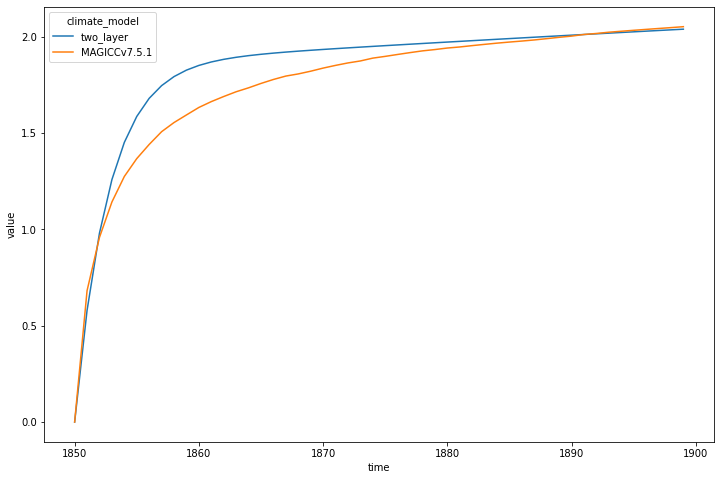

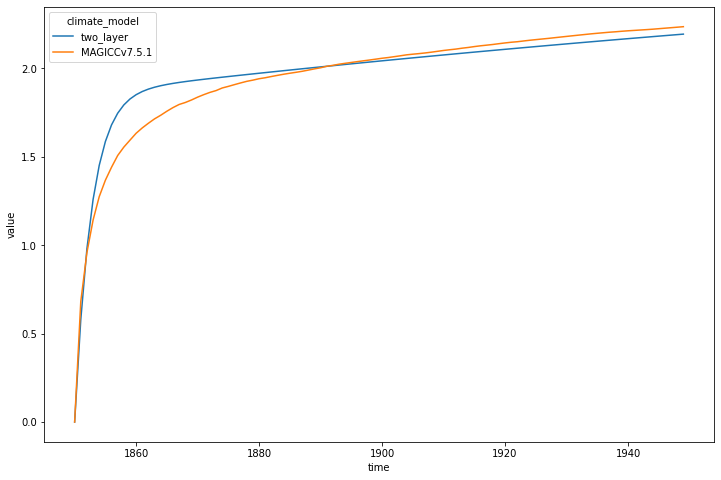

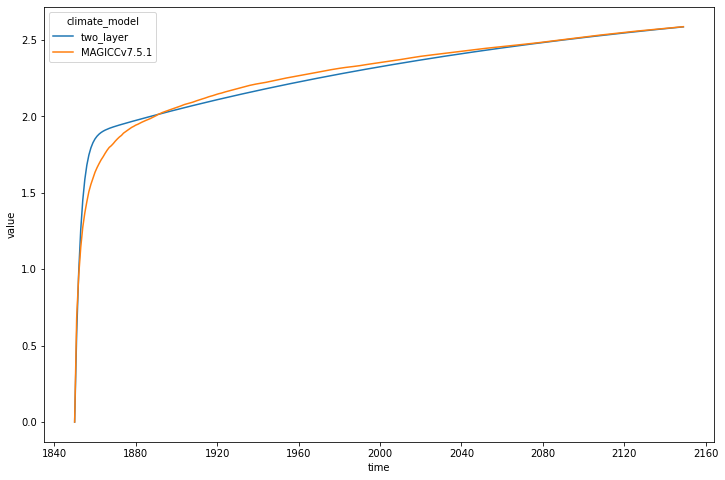

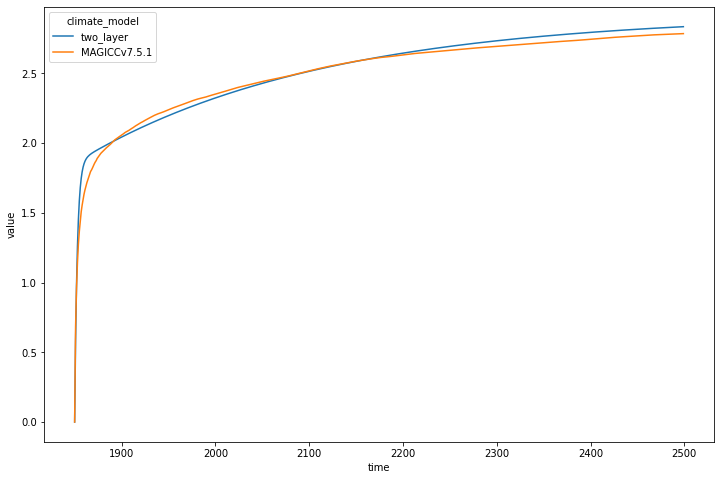

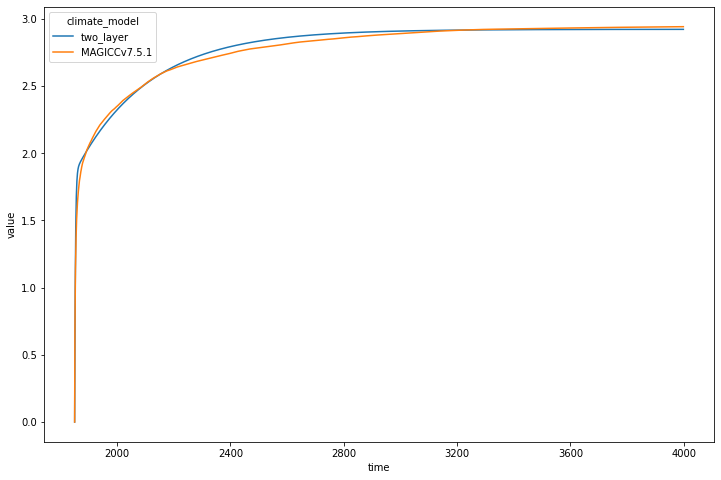

<IPython.core.display.Javascript object>

In [24]:
for yrs in [
    range(1850, 1900),
    range(1850, 1950),
    range(1850, 2150),
    range(1850, 2500),
    range(1850, 4000),
]:
    scmdata.run_append(
        [
            best_res.filter(variable="Surface Temperature|Upper"),
            scmdata.ScmRun(surface_temp_median.copy()),
        ]
    ).filter(year=yrs).lineplot(hue="climate_model")
    plt.show()

In [25]:
def compare_plot(target_values, best_model, driver, ax=None, palette=None, xlim=None):
    best_res = best_model.run_scenarios(scmdata.ScmRun(driver.copy()))
    ax = (
        scmdata.run_append(
            [
                best_res.filter(variable="Surface Temperature|Upper"),
                scmdata.ScmRun(target_values),
            ]
        )
        .filter(year=yrs)
        .lineplot(hue="climate_model", ax=ax, palette=palette)
    )

    if xlim is not None:
        ax.set_xlim(xlim)

    return ax

<IPython.core.display.Javascript object>

In [26]:
def get_summary_paras(mod, name, driver):
    # rebuild the mod_calc to avoid conflicting unit registry errors
    mod_calc = get_irf_model(
        [
            mod.dl.magnitude,
            mod.du.magnitude,
            mod.eta.magnitude,
            mod.lambda0.magnitude,
            mod.efficacy.magnitude,
        ]
    )
    ar6name_attribute_units = (
        ("C", "heat_capacity_upper", "W yr / m^2 / K"),
        ("C_d", "heat_capacity_lower", "W yr / m^2 / K"),
        ("alpha", "lambda0", "W / m^2 / K"),
        ("eta", "efficacy", "dimensionless"),
        ("kappa", "eta", "W / m^2 / K"),
    )
    two_layer_paras = {
        "{} ({})".format(name, unit): getattr(mod_calc, attribute).to(unit).magnitude
        for name, attribute, unit in ar6name_attribute_units
    }

    irf_units = (
        ("d1", "yr"),
        ("d2", "yr"),
        ("q1", "K / (W / m^2)"),
        ("q2", "K / (W / m^2)"),
        ("efficacy", "dimensionless"),
    )
    irf_paras = mod_calc.get_impulse_response_parameters()
    irf_paras = {
        "{} ({})".format(name, unit): irf_paras[name].to(unit).magnitude
        for name, unit in irf_units
    }

    out = {**two_layer_paras, **irf_paras}
    out["id"] = name
    out["ecs (K)"] = calc_ecs(mod_calc, driver).to("K").magnitude
    out["tcr (K)"] = calc_tcr(mod_calc, driver).to("K").magnitude
    out["rf2xCO2 (W / m^2)"] = driver.iloc[0, 0]
    return out


get_summary_paras(best_model, "median", erf_median)

{'C (W yr / m^2 / K)': 6.635936577189717,
 'C_d (W yr / m^2 / K)': 158.98595702280957,
 'alpha (W / m^2 / K)': 1.3157602559179795,
 'eta (dimensionless)': 0.7624070360546147,
 'kappa (W / m^2 / K)': 0.9528668677853567,
 'd1 (yr)': 3.2267183339830785,
 'd2 (yr)': 260.79000649668626,
 'q1 (K / (W / m^2))': 0.48281939623480913,
 'q2 (K / (W / m^2))': 0.27719748032171515,
 'efficacy (dimensionless)': 0.7624070360546147,
 'id': 'median',
 'ecs (K)': 2.92279186189851,
 'tcr (K)': 1.9022673303821378,
 'rf2xCO2 (W / m^2)': 3.8456933682065872}

<IPython.core.display.Javascript object>

In [27]:
xlim_comp = [dt.datetime(1850, 1, 1), dt.datetime(1950, 12, 31)]

<IPython.core.display.Javascript object>

scenarios: 0it [00:00, ?it/s]

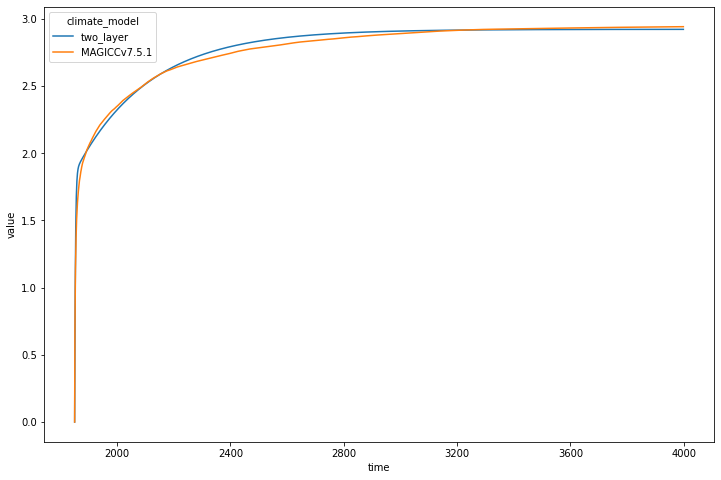

scenarios: 0it [00:00, ?it/s]

2.92279186189851 <Unit('delta_degree_Celsius')>

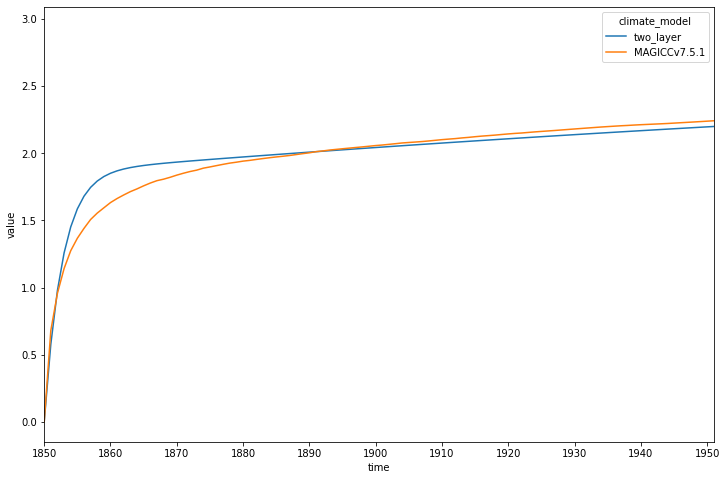

<IPython.core.display.Javascript object>

In [28]:
best_model_median = get_best_fit(surface_temp_median, erf_median)
compare_plot(surface_temp_median, best_model_median, erf_median)
plt.show()
compare_plot(surface_temp_median, best_model_median, erf_median, xlim=xlim_comp)

calc_ecs(best_model_median, erf_median)
calc_ecs(best_model_median, erf_median)

scenarios: 0it [00:00, ?it/s]

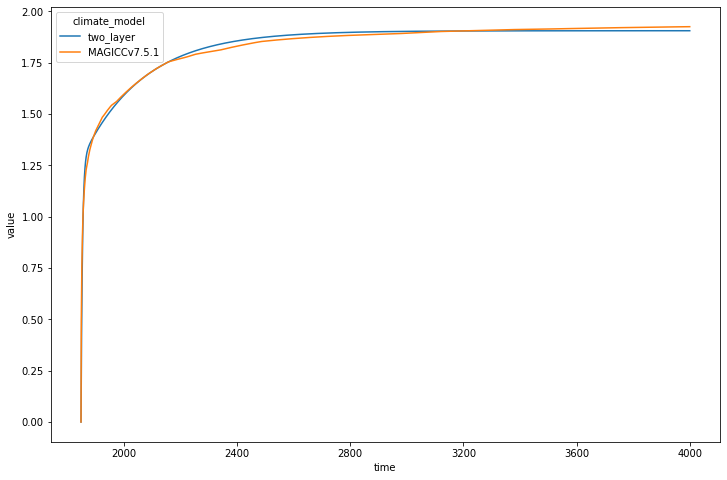

scenarios: 0it [00:00, ?it/s]

1.905421693506982 <Unit('delta_degree_Celsius')>

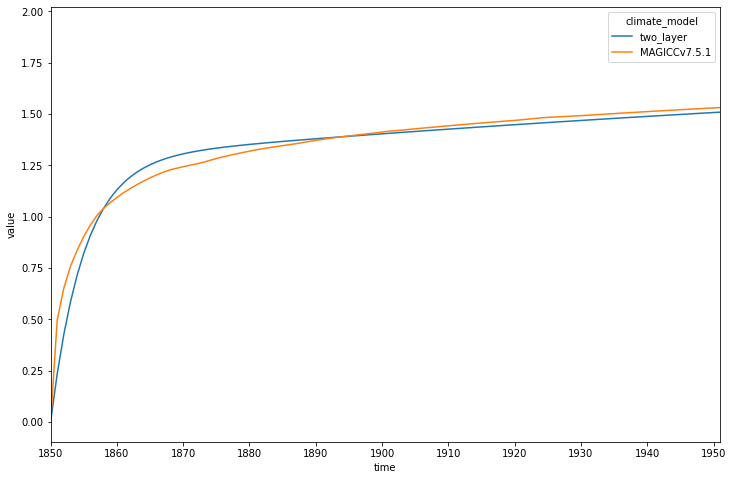

<IPython.core.display.Javascript object>

In [29]:
target_values = surface_temps.process_over("ensemble_member", "quantile", q=0.05)
erf_q05 = erfs.process_over("ensemble_member", "quantile", q=0.05)
best_model_q05 = get_best_fit(target_values, erf_q05)

compare_plot(target_values, best_model_q05, erf_q05)
plt.show()
compare_plot(target_values, best_model_q05, erf_q05, xlim=xlim_comp)
calc_ecs(best_model_q05, erf_q05)

scenarios: 0it [00:00, ?it/s]

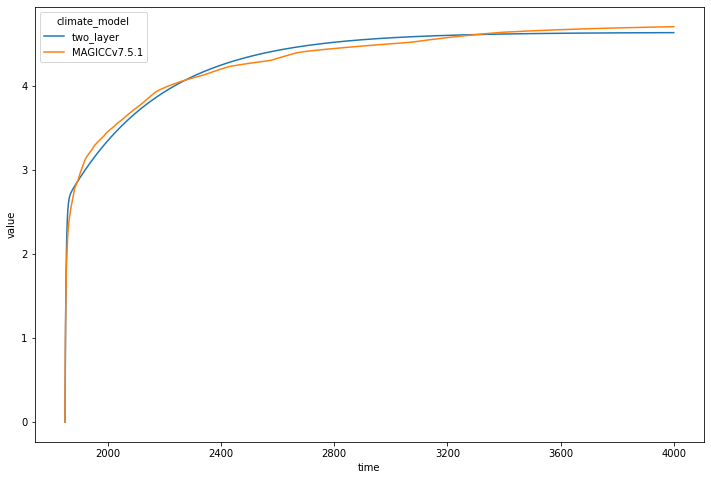

scenarios: 0it [00:00, ?it/s]

4.639324096149034 <Unit('delta_degree_Celsius')>

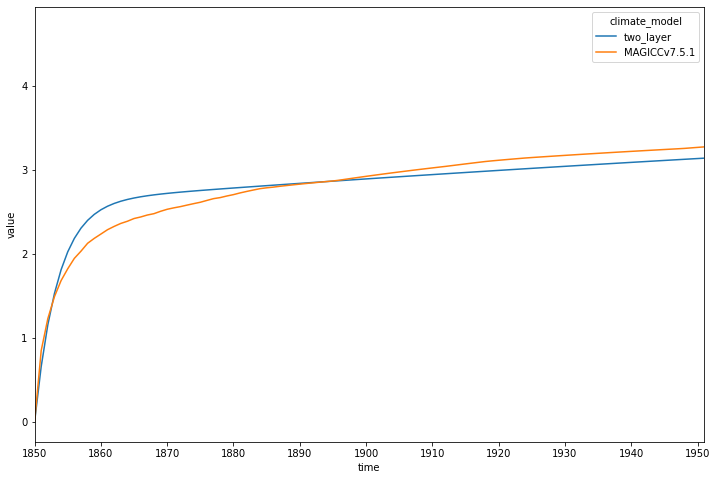

<IPython.core.display.Javascript object>

In [30]:
target_values = surface_temps.process_over("ensemble_member", "quantile", q=0.95)
erf_q95 = erfs.process_over("ensemble_member", "quantile", q=0.95)
best_model_q95 = get_best_fit(target_values, erf_q95)

compare_plot(target_values, best_model_q95, erf_q95)
plt.show()
compare_plot(target_values, best_model_q95, erf_q95, xlim=xlim_comp)

calc_ecs(best_model_q95, erf_q95)

In [31]:
summary_table = [
    get_summary_paras(best_model_median, "median", erf_median),
    get_summary_paras(best_model_q05, "5th percentile", erf_q05),
    get_summary_paras(best_model_q95, "95th percentile", erf_q95),
]

<IPython.core.display.Javascript object>

0it [00:00, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

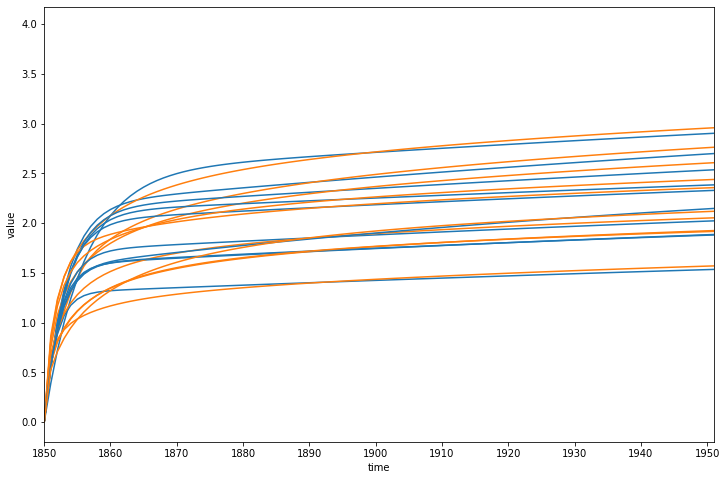

<IPython.core.display.Javascript object>

In [32]:
pool = ProcessPoolExecutor(max_workers=MAX_WORKERS)

futures = []
for i, sdf in tqdman.tqdm(
    enumerate(surface_temps.groupby("ensemble_member")),
):
    target_values = sdf.timeseries()
    em = sdf.get_unique_meta("ensemble_member", True)

    futures.append(
        (
            pool.submit(
                get_best_fit,
                target_values,
                erfs.filter(ensemble_member=em).timeseries(),
                em,
            )
        )
    )
#     if i > 10:
#         break

for i, future in tqdman.tqdm(
    enumerate(as_completed(futures, timeout=None)), total=len(futures)
):
    try:
        best_model, em = future.result()
        erf = erfs.filter(ensemble_member=em).timeseries()
        summary_table.append(
            get_summary_paras(
                best_model,
                "ensemble member {}".format(em),
                erf,
            )
        )
        if i < 10:
            compare_plot(
                surface_temps.filter(ensemble_member=em).timeseries(),
                best_model,
                erf,
                xlim=xlim_comp,
            )
    except Exception as exc:
        traceback.print_exc()

plt.gca().get_legend().remove()

In [33]:
summary_table = pd.DataFrame(summary_table).set_index("id")
summary_table

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  \
id                                                              
median                         6.635937            158.985957   
5th percentile                14.214921            159.316394   
95th percentile                6.537695            158.972901   
ensemble member 18             6.638006            158.977297   
ensemble member 7             10.862616            159.788960   
...                                 ...                   ...   
ensemble member 589           12.587042            158.214405   
ensemble member 597            6.649942            158.976139   
ensemble member 583           17.177183            159.329547   
ensemble member 598            7.774907            159.033163   
ensemble member 588           14.926644            160.243025   

                     alpha (W / m^2 / K)  eta (dimensionless)  \
id                                                              
median                          1.315760             0.762407   
5th percentile                  1.749939             0.741420   
95th percentile                 0.931663             0.828348   
ensemble member 18              1.045640             0.619081   
ensemble member 7               1.088774             0.679554   
...                                  ...                  ...   
ensemble member 589             1.173144             0.971798   
ensemble member 597             0.911674             0.764637   
ensemble member 583             1.814964             0.825085   
ensemble member 598             1.428233             0.951177   
ensemble member 588             1.966532             0.745123   

                     kappa (W / m^2 / K)   d1 (yr)     d2 (yr)  \
id                                                               
median                          0.952867  3.226718  260.790006   
5th percentile                  1.086569  5.494943  216.751156   
95th percentile                 0.836230  3.988354  334.479366   
ensemble member 18              1.116366  3.781022  239.097169   
ensemble member 7               0.846742  6.448422  291.970330   
...                                  ...       ...         ...   
ensemble member 589             0.737131  6.582661  349.842194   
ensemble member 597             1.063727  3.808008  286.274191   
ensemble member 583             1.012503  6.395659  232.862046   
ensemble member 598             0.704345  3.685997  333.459461   
ensemble member 588             1.119249  5.269997  206.206870   

                     q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                            
median                         0.482819            0.277197   
5th percentile                 0.381753            0.189696   
95th percentile                0.604464            0.468885   
ensemble member 18             0.563388            0.392964   
ensemble member 7              0.586298            0.332166   
...                                 ...                 ...   
ensemble member 589            0.516654            0.335756   
ensemble member 597            0.565570            0.531313   
ensemble member 583            0.367290            0.183686   
ensemble member 598            0.471562            0.228604   
ensemble member 588            0.348983            0.159527   

                     efficacy (dimensionless)   ecs (K)   tcr (K)  \
id                                                                  
median                               0.762407  2.922792  1.902267   
5th percentile                       0.741420  1.905422  1.264958   
95th percentile                      0.828348  4.639324  2.661825   
ensemble member 18                   0.619081  3.692390  2.259617   
ensemble member 7                    0.679554  3.899937  2.416516   
...                                       ...       ...       ...   
ensemble member 589                  0.971798  2.865431  1.679195   
ensemble member 597          

<IPython.core.display.Javascript object>

In [34]:
tmp = summary_table[summary_table["ecs (K)"] < 0]
assert tmp.empty

<IPython.core.display.Javascript object>

In [36]:
summary_table.to_csv(OUT_FILE)
OUT_FILE

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/irf_from_2xCO2_2021_02_17_233041.csv'

<IPython.core.display.Javascript object>

ecs (K)
1.418043584127004
1.9054917580029571
2.919631802340613
4.672807393635288
6.933798701413124

tcr (K)
0.9947123731182398
1.2746581918468094
1.886317172597034
2.620041349048444
3.4092710338721774



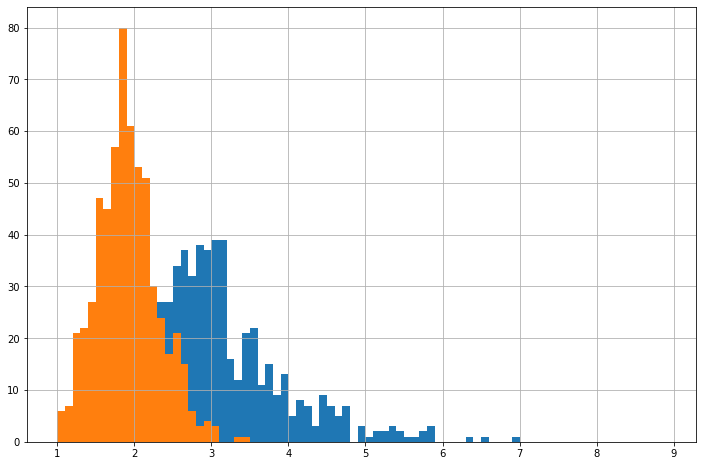

<IPython.core.display.Javascript object>

In [37]:
for col in [
    "ecs (K)",
    "tcr (K)",
    #     "C (W yr / m^2 / K)",
    #     "C_d (W yr / m^2 / K)",
    #     "alpha (W / m^2 / K)",
    #     "eta (dimensionless)",
    #     "kappa (W / m^2 / K)",
    #     "efficacy (dimensionless)",
]:
    print(col)
    summary_table[col].hist(bins=np.arange(1, 9, 0.1))
    print(summary_table[col].quantile(q=0))
    print(summary_table[col].quantile(q=0.05))
    print(summary_table[col].median())
    print(summary_table[col].quantile(q=0.95))
    print(summary_table[col].quantile(q=1))
    print()

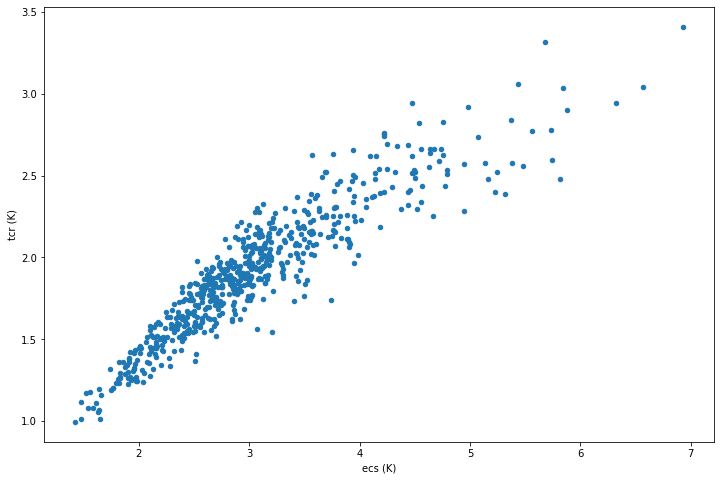

<IPython.core.display.Javascript object>

In [38]:
summary_table.plot.scatter(x="ecs (K)", y="tcr (K)")